# Code for the paper "Why do inequality and deprivation produce high crime and low trust"

In [10]:
#Load the packages

from scipy.stats import norm
from scipy.special import binom as binom_coef
import multiprocessing as mtp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [23]:
#Set initial values for the environment parameters
x = 1 # investment in cooperation
Sigma = 5 # variance of states in the population
u = 2 # mean state in the population
r = 0.9 # Social immobility
a = 1.2 # Cooperation efficiency
penalty = 5 # Fitness imapct of being under the desperation threshold
possible_states = np.round(np.linspace(-50,50,1001),1) # Discrete pace of the possible state values (from -50 to 50)
risk_of_stealing = 1/3 # Probability of being punished when trying to exploit
success_steal_prob = (1-risk_of_stealing)
punishment = 10 # Severity of punishment in fitness units

## Let's create the function for the dynamic programming, with some subfunctions first

In [16]:
# This function creates a discretized normal distribution
# It returns the probabilities of being at state x (which can be a vector),
# if the expectancy is loc (also possibly a vector) and the s.d. scale
def norm_distrib(x,loc,scale=np.sqrt(1-r**2)*Sigma):
    x = np.array(x)
    loc = np.array(loc)
    x = np.tile(x,(loc.size,1))
    loc = np.tile(loc,(loc.size,1))
    z = (scale/np.sqrt(2*np.pi))*np.exp(-(x-loc.T)**2/(2*scale**2))
    return z/z.sum(1,keepdims=1)

# This function creates a probability transition matrix :
# it gives, for each state value, the probability to reach any other state value 
#("modif" is the increment due to the agent's action)
def probas(modif):
    z = (norm_distrib(x = possible_states,loc = r*possible_states + (1-r)*u + modif,scale = np.sqrt(1-r**2)*Sigma))
    return(z)

#This function is just a shortcut to transform a state value into its position in the vector "possible_states"
def as_state(state):
    return(np.where(possible_states==state)[0][0])

# This is the crucial function: it runs a dynamic programming algorithm to compute the optimal decisions for given parameters
# p is the probability of being exploited
# T is the number of iterations (or the terminal time in dynamic programming slang)
def dyn_prog(p,T=100):
    # We first associate each action with a transition probability matrix
    PROBAS_COOPERATE = p*probas(-x) + (1-p)*probas((a-1)*x)
    PROBAS_STEAL = (1-success_steal_prob)*probas(-punishment*x) + success_steal_prob*probas(5*x)
    PROBAS_HIDE = probas(0)
    # We initiate empty arrays to record, for each state and each time, the optimal actions
    optimal_decisions = np.empty((T,possible_states.size), dtype='int8')
    # Idem for the fitness values
    Fitness = np.empty((T+1,possible_states.size))
    # This function search, in time t, the fitness values for every state
    def fitness(t):
        return (Fitness[t,]-(possible_states<0)*penalty).clip(0,)
    # We initiate the fitness vector in the terminal time
    Fitness[T,] = (50+possible_states)/2
    for t in reversed(range(T)):             
        # For each of the three actions, we compute a vector giving the expected fitness at each state
        s = np.dot(PROBAS_STEAL,fitness(t+1))
        h = np.dot(PROBAS_HIDE,fitness(t+1))
        c = np.dot(PROBAS_COOPERATE,fitness(t+1))
        # We combine the three payoffs vectors
        payoffs = np.array([s,h,c])
        # We compare the values at each state
        Fitness[t,] = np.max(payoffs,axis=0) # the max becomes the fitness value at this state in time t
        optimal_decisions[t,] = np.argmax(payoffs,axis=0) # the argmax is the optimal decision
    return(optimal_decisions[0],p,Fitness[0])

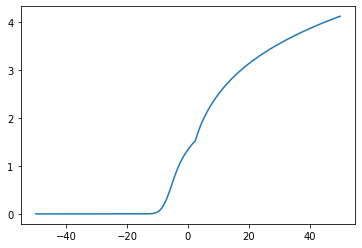

In [24]:
A = dyn_prog(0)[2]
plt.plot(possible_states,A)

In [ ]:
precision = 50 
N = 100
n = 5

def States(Z):
    return([Z.Pop[i].state for i in range(len(Z.Pop))])
def Trusts(Z):
    return([1-Z.Pop[i].social_distrust for i in range(len(Z.Pop))])
def Types(P):
    return([P.Pop[i].type for i in range(len(P.Pop))])
def Enforce(P):
    return([P.Pop[i].enforce for i in range(len(P.Pop))])


def distrust(f,q):
    if f == precision:
        return 1-q/2
    est = np.round(f/precision*N*n)
    p = 1- binom_coef(N*n-est-1,n-1)/binom_coef(N*n-1,n-1)
    return(p*(1-q/2))
def enforce_belief(q):
    if q == precision:
        return 1
    est = round(q/precision*N*n) 
    return(1 - binom_coef(N*n-est-1,n-1)/binom_coef(N*n-1,n-1))

def create(params):
    file = f"./Desktop/Nettle/Library/a={a}_punish={punishment}_risk={risk}p={params[0]}_q={params[1]}_u={u}_r={r}_Sigma={Sigma}_precision={precision}_n={n}_N={N}"
    if (not os.path.exists(file+"_D.npy")) or (not os.path.exists(file+"_E.npy")):
        D = dyn_prog2(params,speeding=False)
        return(params,D[0],D[1])
    else:
        return params,a